<a href="https://colab.research.google.com/github/laurilaatu/malis/blob/master/MALIS_Project_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MALIS 2019 EURECOM
## Course Project

This is version zero of our semester project. We will load and prepare the data. Train a CNN to to extract features and use an ANN or SVM to classify the images.

### Description

**Task 1**: **bold text** Project definition for Group 34
	By:
Lauri Laatu
Marvin Mouroum


**•Context & problem definition**

Classifying images is a huge topic in machine learning. The goal for our project is to be able to classify images to multiple classes. More specifically we want to investigate if a simple convolutional neural network is able to classify internet memes correctly. As such our it is a supervised learning problem.


**•Methodology**

Convolution for feature extraction
RGB images will be fetched from a database
preprocessing to optimize image dimensions
convolution over three color channels of the images
exporting a feature vector containing compressed information about the image
ANN or SVM for classification based on extracted features
feature vectors as labeled input
supervised multiclass classification problem
dataset usage: initially we plan to start with n-fold cross validation and 10% testing
classification in predefined meme categories


**•Data**

The data will be acquired from the internet and labeled by hand if the data is unlabelled. Goal is to find around a thousand images per class.


# Dataset
Loading data from the dataset

In [0]:
import os.path
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import drive as gdrive
from pydrive.auth import GoogleAuth

from IPython.display import Image

In [0]:
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
gdrive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Copy raw pepe images to local directory

In [0]:
!mkdir  dataset

file_list = drive.ListFile({'q': "'10DpgRQAxqIU0TLYCruSGPaj3DfRzh6TE' in parents and trashed=false"}).GetList()

root = "/content/drive/My Drive/MALIS_Project/DataSet/rare-pepes/"
i = 0

#!cp "/content/drive/My Drive/MALIS_Project/DataSet/rare-pepes/001 - OdrldTF.png" "dataset/pepe_00.png"

for file in file_list:
  target = "'dataset/pepe_"+str(i)+".png'"
  src    = "'"+root+file['title']+"'"
  #print(src)
  #print(target)
  !cp $src $target
  i+=1

!ls -1 dataset



### Resizing Image so it can be used by the CNN

In [0]:
def resize_img(img,destination):
  # Create square images from pepes by adding black margins preserving original aspect ratio
  #Importing modules opencv + numpy
  import cv2
  import numpy as np

  #Reading an image (you can use PNG or JPG)
  img = cv2.imread(img)

  if img is None:
    return False

  #Getting the bigger side of the image
  s = max(img.shape[0:2])

  #Creating a dark square with NUMPY  
  f = np.zeros((s,s,3),np.uint8)

  #Getting the centering position
  ax,ay = (s - img.shape[1])//2,(s - img.shape[0])//2

  #Pasting the 'image' in a centering position
  f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img

  #Showing results (just in case) 
  #cv2.imshow("IMG",f)
  #A pause, waiting for any press in keyboard
  #cv2.waitKey(0)

  #Saving the image
  f = cv2.resize(f,(227,227),interpolation=cv2.INTER_AREA)
  cv2.imwrite(destination,f)
  cv2.destroyAllWindows() 
  return True

In [0]:
!mkdir resized
for i in range(0,1273):
  path =   "dataset/pepe_" + str(i) + ".png"
  _path = "'resized/pepe_" + str(i) + ".png'"
  prev_dest = "resized/pepe_" + str(i) + ".png"
  destination = "'/content/drive/My Drive/MALIS_Project/DataSet/resized_pepe/pepe_" + str(i) + ".png'"
  if not resize_img(path,prev_dest):
    print("error with", i)
  !cp $_path $destination 
  if(i%50 == 0):
    print(i)

### Prepare the Not Pepe Images

In [0]:
file_list = drive.ListFile({'q': "'1UBhhkryHE302KDQ8ufDvkfv7vozMZfli' in parents and trashed=false"}).GetList()

!mkdir dataset

root = "/content/drive/My Drive/MALIS_Project/DataSet/not-pepes/"
i = 0
rootfolder = "'"+root+"'"

#!cp "/content/drive/My Drive/MALIS_Project/DataSet/rare-pepes/001 - OdrldTF.png" "dataset/pepe_00.png"

for file in file_list:
  target = "dataset/not_pepe_"+str(i)+"."+file['title'].split('.')[-1]
  src    =  root+file['title']
  _src   = "'"+target+"'"  
  _target = "'/content/drive/My Drive/MALIS_Project/DataSet/resized_not_pepe/not_pepe_"+str(i)+"."+file['title'].split('.')[-1]+"'"
  
  if not resize_img(src,target):
    print("error with", i)
    continue
  !cp $_src $_target
  i+=1

In [0]:
!ls '/content/drive/My Drive/MALIS_Project/DataSet/not-pepes/'

# Network

In [0]:
## PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor
import torch.optim as optim
import torchvision

import math #for calculus
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

from sklearn import svm

Defining the Network class

In [0]:
class PepeNN(nn.Module):   
    
    def __init__(self,name='PepeNN'):
        super(PepeNN, self).__init__()
        self.T = 120
        
        self.name = name
        
        self.training_epochs = 0
        
        self.lr_history       = []
        self.accuracy_history = []
        self.loss_history     = []
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

        self.conv1 = nn.Conv2d(3,20,  kernel_size=(11,11),stride=(4,4),padding=(1,1),dilation=(1,1))
        self.batchnorm1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20,40,kernel_size=(5,5),stride=(2,2),padding=(1,1),dilation=(1,1))
        self.batchnorm2 = nn.BatchNorm2d(40)

        self.pooling1 = nn.MaxPool2d( kernel_size=(5,5), stride=(2,2), padding=(1,1), dilation=(1,1))

        self.conv3 = nn.Conv2d(40,20,kernel_size=(3,3),stride=(2,2),padding=(1,1),dilation=(1,1))
        self.batchnorm3 = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20,10,kernel_size=(2,2),stride=(1,1),padding=(0,0),dilation=(1,1))
        self.batchnorm4 = nn.BatchNorm2d(10)

        self.pooling2 = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(0,0), dilation=(1,1))
        
        #fully connected at the end

        self.fc1 = torch.nn.Linear(in_features=250, out_features=2)
        #self.fc1 = torch.nn.Linear(in_features=250, out_features=125)
        #self.fc2 = torch.nn.Linear(in_features=125, out_features=2)
    
        
        # robust weight initialization
        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.xavier_normal_(self.conv3.weight)
        torch.nn.init.xavier_normal_(self.conv4.weight)

        torch.nn.init.xavier_normal_(self.fc1.weight)
        #torch.nn.init.xavier_normal_(self.fc2.weight)

        self.SVM = svm.LinearSVC()
        self.svm_train_input = []
        self.svm_label_input = []
        self.svm_active = False
        self.SVM.max_iter = 10000
        self.SVM.C = 0.01
      

        
    def forward(self, x):

        batchSize = x.shape[0]

        # first set of CNNs and then a max pool
        #print("starting with " + str(x.shape))
        x = self.conv1(x)
       # print("after 1 " + str(x.shape))
        x = self.batchnorm1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        #print("after 2 " + str(x.shape))
        x = self.batchnorm2(x)
        x = F.relu(x)
        
        x = self.pooling1(x)
        #print("after 3 " + str(x.shape))
        
        # second set
        
        x = self.conv3(x)
        #print("after 4 " + str(x.shape))
        x = self.batchnorm3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        #print("after 5 " + str(x.shape))
        x = self.batchnorm4(x)
        x = F.relu(x)
        
        x = self.pooling2(x)
        #print("after 6 " + str(x.shape))
        mean = x.mean()
        std = x.std()
        svm_input = (x - mean)/std
        res = []

        if self.svm_active:
          if len(self.svm_train_input) == 0:
            self.svm_train_input.append(svm_input)
          else:

            if self.svm_train_input[0].ndim == 5:
              n = self.svm_train_input[0].shape[0]
              b = self.svm_train_input[0].shape[1]
              h = self.svm_train_input[0].shape[2]
              w = self.svm_train_input[0].shape[3]
              d = self.svm_train_input[0].shape[4]

              self.svm_train_input[0] = torch.cat([self.svm_train_input[0], svm_input.reshape([1,b,h,w,d])], dim=0)
            else:
              self.svm_train_input[0] = torch.stack([self.svm_train_input[0], svm_input], dim=0)

        else:
          b,h,w,d = svm_input.shape
          predict_input = svm_input.clone().detach().cpu().reshape(b,h*w*d).tolist()
          res = self.SVM.predict(predict_input)

        x= self.fc1(x.reshape((batchSize,250)))
        #x= self.fc2(x)

        x= F.softmax(x,dim=1)
        
        return x, res
      
    def save(self,root='gdrive/My\ Drive/MALIS_Project'):
      !mkdir $root
  
      path = root.replace('\\','') + '/' + self.name + '.pickle'
    
      print("\nsaving network under:\n",path)
      
      with open(path, 'wb') as f:
        pickle.dump(self, f)
        
    def next_epoch(self,lr,acc_hist,loss_hist):
      self.training_epochs += 1
      self.lr_history.append(lr)
      self.accuracy_history.append(acc_hist)
      self.loss_history.append(loss_hist)
    
    def reset(self):
      self.training_epochs = 0
      self.lr_history = []
      self.accuracy_history = []
      self.loss_history = []

    def train_svm(self):
      print(len(self.svm_train_input))
      print(len(self.svm_label_input))
      print(self.svm_train_input[0].shape)
      print(self.svm_label_input[0].shape)

      inputs = []
      labels = []

      i_clone = self.svm_train_input[0].clone().detach().cpu().numpy()
      i_clone = i_clone.reshape(i_clone.shape[0]*i_clone.shape[1],i_clone.shape[2]*i_clone.shape[3]*i_clone.shape[4])
      inputs = i_clone.tolist()

      l_clone = self.svm_label_input[0].clone().detach().cpu().numpy() 
      l_clone = l_clone.reshape(l_clone.shape[0]*l_clone.shape[1])
      labels = l_clone.tolist()


      print(len(inputs))
      print(len(labels))

      print(inputs[0])
      print(labels[0])

      self.SVM.fit(inputs, labels)

    def add_svm_labels(self,labels):
      if len(self.svm_label_input) == 0:
        #print("first append svm training label")
        self.svm_label_input.append(labels)
      else:

        if self.svm_label_input[0].ndim == 2:
          n = self.svm_label_input[0].shape[0]
          b = self.svm_label_input[0].shape[1]

          #print(self.svm_label_input[0].shape)
          #print(labels.reshape([1,b]).shape)

          self.svm_label_input[0] = torch.cat([self.svm_label_input[0], labels.reshape([1,b])], dim=0)
        else:
          #print(self.svm_label_input[0].shape)
          #print(labels.shape)
          self.svm_label_input[0] = torch.stack([self.svm_label_input[0], labels], dim=0)

        
      #self.svm_label_input.append(labels)
    
    def newEpoch(self):
      self.svm_train_input.clear()
      self.svm_label_input.clear()


Creating n folds

In [0]:
#!ls "/content/drive/My Drive/MALIS_Project/DataSet/"


# id for Dataset folder 1ugHotUpAsw1o-V8JvN7JwEXWNv-tTp-i

file_list = drive.ListFile(
    {'q': "'1ugHotUpAsw1o-V8JvN7JwEXWNv-tTp-i' in parents"}).GetList()

# create an array of tuples with (id, label, fold,file)

dataset = []
npepes = []

pepes = []

for i in file_list:
  if "resized" in i['title']:
    if "not" in i['title']:
      print(i)
      for notpepe in drive.ListFile({'q': "'%s' in parents"%(i['id']) }).GetList():
        # 
        npepes.append((len(dataset), 0, None, notpepe))
      #print(i)
    else:
      for pepe in drive.ListFile({'q': "'%s' in parents"%(i['id']) }).GetList():
        # 
        pepes.append((len(dataset), 1, None, pepe))      
      #print(i)
  

print(len(npepes),len(pepes))

folds = 6
for fold in range(folds):
  foldsize = int(len(npepes)/folds)
  for i in range(fold*foldsize, (fold+1)*foldsize):
    npepes[i] = (npepes[i][0], npepes[i][1], fold, npepes[i][3])

for i in range(len(npepes)-1,1, -1):
  if npepes[i][2] is None:
    npepes[i] = (npepes[i][0], npepes[i][1], folds-1, npepes[i][3])
  else:
    break

for fold in range(folds):
  foldsize = int(len(pepes)/folds)
  for i in range(fold*foldsize, (fold+1)*foldsize):
    pepes[i] = (pepes[i][0], pepes[i][1], fold, pepes[i][3])

for i in range(len(pepes)-1,1, -1):
  if pepes[i][2] is None:
    pepes[i] = (pepes[i][0], pepes[i][1], folds-1, pepes[i][3])
  else:
    break

for x in npepes[-5:]:
  print(x)

for x in pepes[-5:]:
  print(x)

# now we have labeled dataset partitioned into n number of folds  
dataset = npepes+pepes
print(len(dataset))


    

#print(file_list)

In [0]:
dataset[3000]

### Methods for training the network

Some methods...

In [0]:
def get_cost_function():
    
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function
    
def get_optimizer(net, lr, wd, momentum):
  #optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False)
  return optimizer

In [0]:
def test(net,t_data,t_labels, cost_function, device='cuda:0'):
  
  net.eval()
  net.svm_active = False

  cumulative_loss = 0
  accuracy = 0
  svm_accuracy = 0

  samples = t_data.shape[0]

  misclassified_imgs = []
  svm_misclassified_imgs = []
  
  with torch.no_grad():

    mean = t_data.mean()
    std  = t_data.std()
      
    t_data = (t_data - mean)/std
      
    # Load data into GPU
    inputs = torch.LongTensor(t_data).float().to(device)
    targets = torch.LongTensor(t_labels).to(device)
        
    # Forward pass
    outputs, svm_outputs = net(inputs)
      
    # Apply the loss
    loss = cost_function(outputs, targets)

    #print("loss " +str(loss))
    cumulative_loss += loss.item()
    #print("cim loss " +str(cumulative_loss))
    _, predicted = outputs.max(1)
    svm_predicted = torch.LongTensor(svm_outputs)
    #print("ourputs -> " , outputs)
    #print("predicted -> " , predicted)
    #print("targets   -> " , targets)

    misclassified = (predicted.eq(targets) == 0).nonzero()
    for i in misclassified:
        misclassified_imgs.append((i, predicted[i]))

    svm_misclassified = (svm_predicted.eq(targets.clone().cpu().detach()) == 0).nonzero()
    for i in svm_misclassified:
        svm_misclassified_imgs.append((i, svm_predicted[i]))

    accuracy += predicted.eq(targets).sum().item()/samples
    svm_accuracy += svm_predicted.eq(targets.clone().cpu().detach()).sum().item()/samples
    #print("accuracy " + str(accuracy))

  return cumulative_loss, accuracy, svm_accuracy, misclassified_imgs, svm_misclassified_imgs

In [0]:
def train(net,t_data,t_labels,optimizer,cost_function, device='cuda:0'):
  net.train()
  net.svm_active = True

  cumulative_loss = 0
  accuracy = 0

  samples = t_data.shape[0]

  mean = t_data.mean()
  std  = t_data.std()
      
  t_data = (t_data - mean)/std
      
  # Load data into GPU
  inputs = torch.LongTensor(t_data).float().to(device)
  targets = torch.LongTensor(t_labels).to(device)
        
  # Forward pass
  outputs, svm_inputs = net(inputs)
  net.add_svm_labels(targets)
      
  # Apply the loss
  loss = cost_function(outputs, targets)

  # Backward pass
  loss.backward()
    
  # Update parameters
  optimizer.step()
    
  # Reset the optimizer
  optimizer.zero_grad()

  #print("loss " +str(loss))
  cumulative_loss += loss.item()
  #print("cim loss " +str(cumulative_loss))
  _, predicted = outputs.max(1)
  #print("ourputs -> " , outputs)
  #print("predicted -> " , predicted)
  #print("targets   -> " , targets)
  accuracy += predicted.eq(targets).sum().item()/samples
  #print("accuracy " + str(accuracy))

  return cumulative_loss, accuracy

In [0]:
from random import shuffle

#dataset[3000][1] -> label
#dataset[3000][2] -> n fold


first_fold = list(filter(lambda x: x[2] == 0, dataset))
second_fold = list(filter(lambda x: x[2] == 1, dataset))
third_fold = list(filter(lambda x: x[2] == 2, dataset))
fourth_fold = list(filter(lambda x: x[2] == 3, dataset))
fifth_fold = list(filter(lambda x: x[2] == 4, dataset))
#print(len(first_fold))

trainingData = [first_fold,second_fold,third_fold,fourth_fold,fifth_fold]

def getTrainingData(n_fold):

  shuffle(n_fold)

  images  = list(map(lambda x: x[3], n_fold))
  classes  = list(map(lambda x: x[2], n_fold))
  labels = list(map(lambda x: x[1], n_fold))

  imageArray = np.zeros((len(images),227,227,3))

  for i in range(0,len(images)):
    standard = 'drive/My Drive/'
    root = standard + 'MALIS_Project/DataSet/'

    if (labels[i] == 0):
      root = root + 'resized_not_pepe/'

    else:
      root = root + 'resized_pepe/'

    filepath = root + images[i]['title']
    image = cv2.imread(filepath) #numpy array
    if image.size == 0:
      print("empty image")
    imageArray[i] = image

  return imageArray, labels




In [0]:
net = PepeNN()

In [184]:

device='cuda:0'
net.to(device)

testLoss = 0
trainLoss = 0
total_acc = 0
counter = 0

max_epochs = 10
lr = 0.001

for e in range(0,max_epochs):
  
  if counter > 0 and total_acc/counter > 0.99:
    print("accuracy high enough aborting")
    break

  print("On epoch ", e)
  net.newEpoch()

  for _n in range(0,4):
    imageArray, labels = getTrainingData(trainingData[_n])
    a=0
    n=20
    N= imageArray.shape[0]

    intervall = n-a

    for i in range(0,N,intervall):
    
      a = i
      n = i + intervall

      if n >= N:
        continue

      t_data   = np.transpose(imageArray[a:n].reshape((n-a,227,227,3)), (0,3, 1, 2))
      t_labels = np.array([labels[a:n]]).reshape((n-a,))

      if t_data.size == 0:
        print("skip")
        continue

      #tLoss, accuracy =test(net,t_data,t_labels,get_cost_function(),device)
      #testLoss += tLoss

      optimizer = get_optimizer(net, lr=lr, wd=1e-6, momentum=0.9)

      Loss, accuracy = train(net,t_data,t_labels,optimizer,get_cost_function(),device)
      trainLoss += Loss
      #print("accumulated loss = " +str(trainLoss))
      #print("accuracy -> " + str(accuracy))
      total_acc += accuracy
      counter += 1

    print("\nNEXT FOLD\n")
  print("accuracy ",total_acc/counter)
    
net.train_svm()


On epoch  0

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.8037037037037036
On epoch  1

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.8421296296296292
On epoch  2

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.8618827160493812
On epoch  3

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.8761574074074043
On epoch  4

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.8853703703703667
On epoch  5

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.8941358024691338
On epoch  6

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.9002645502645503
On epoch  7

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.9059027777777797
On epoch  8

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.9103395061728425
On epoch  9

NEXT FOLD


NEXT FOLD


NEXT FOLD


NEXT FOLD

accuracy  0.9140277777777818
1
1
torch.Size([108, 20, 10, 5, 5])
torch.Size([108, 20])
2160
2160
[-0.9765424728393555, -0.8643355965614319,

In [217]:
net.SVM.C = 0.01
net.train_svm()

1
1
torch.Size([108, 20, 10, 5, 5])
torch.Size([108, 20])
2160
2160
[-0.9765424728393555, -0.8643355965614319, -0.8643355965614319, -0.9765424728393555, 0.5006853938102722, -0.545567512512207, -0.545567512512207, -0.2760240435600281, -0.2760240435600281, 0.15311512351036072, 1.640899419784546, 1.640899419784546, 0.529654860496521, 1.6624277830123901, 1.6624277830123901, 1.640899419784546, 1.640899419784546, 0.529654860496521, 1.6624277830123901, 1.6624277830123901, -0.9765424728393555, -0.9765424728393555, -0.9765424728393555, -0.9765424728393555, -0.4361077845096588, -0.8905236124992371, -0.9765424728393555, -0.9765424728393555, -0.9765424728393555, -0.3327436149120331, -0.00736685935407877, -0.07248390465974808, -0.9765424728393555, -0.9765424728393555, -0.5676108598709106, 0.4245870113372803, -0.07248390465974808, -0.9765424728393555, -0.9765424728393555, 0.07498587667942047, 0.5247576236724854, -0.3901652693748474, -0.3901652693748474, 0.17859961092472076, 0.8328937888145447, 0.524

net classified as: tensor([0], device='cuda:0') (tensor([10], device='cuda:0'), tensor([0], device='cuda:0'))


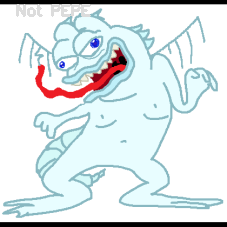

net classified as: tensor([0], device='cuda:0') (tensor([12], device='cuda:0'), tensor([0], device='cuda:0'))


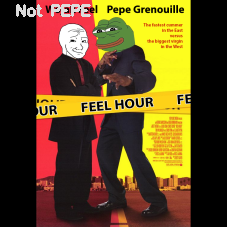

net classified as: tensor([0], device='cuda:0') (tensor([13], device='cuda:0'), tensor([0], device='cuda:0'))


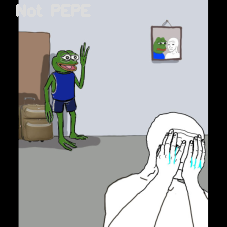

svm classified as: tensor([0]) (tensor([10]), tensor([0]))


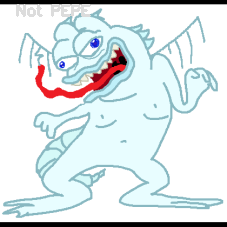

svm classified as: tensor([0]) (tensor([13]), tensor([0]))


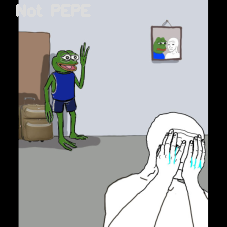

net classified as: tensor([0], device='cuda:0') (tensor([4], device='cuda:0'), tensor([0], device='cuda:0'))


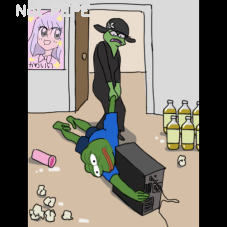

net classified as: tensor([0], device='cuda:0') (tensor([2], device='cuda:0'), tensor([0], device='cuda:0'))


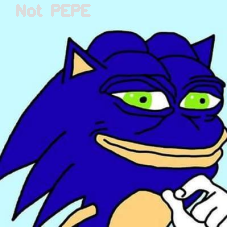

net classified as: tensor([0], device='cuda:0') (tensor([15], device='cuda:0'), tensor([0], device='cuda:0'))


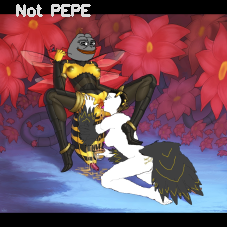

svm classified as: tensor([0]) (tensor([2]), tensor([0]))


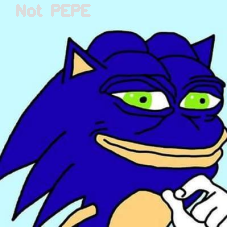

svm classified as: tensor([0]) (tensor([15]), tensor([0]))


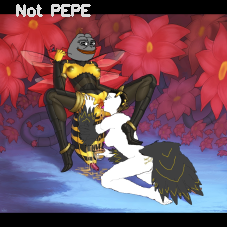

net classified as: tensor([0], device='cuda:0') (tensor([3], device='cuda:0'), tensor([0], device='cuda:0'))


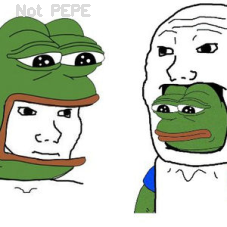

svm classified as: tensor([0]) (tensor([3]), tensor([0]))


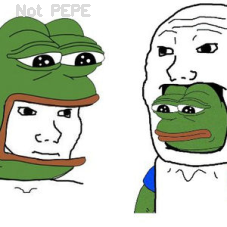

net classified as: tensor([0], device='cuda:0') (tensor([3], device='cuda:0'), tensor([0], device='cuda:0'))


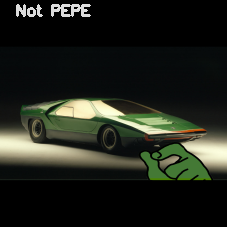

net classified as: tensor([0], device='cuda:0') (tensor([5], device='cuda:0'), tensor([0], device='cuda:0'))


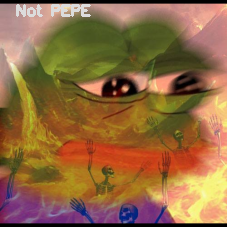

svm classified as: tensor([0]) (tensor([3]), tensor([0]))


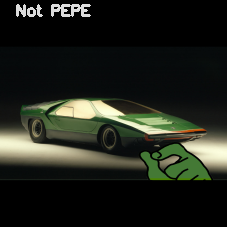

svm classified as: tensor([0]) (tensor([5]), tensor([0]))


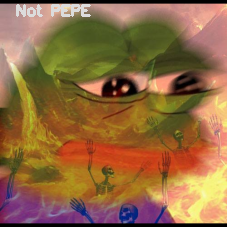

svm classified as: tensor([0]) (tensor([15]), tensor([0]))


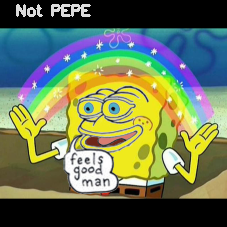

net classified as: tensor([0], device='cuda:0') (tensor([16], device='cuda:0'), tensor([0], device='cuda:0'))


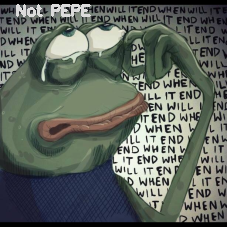

svm classified as: tensor([0]) (tensor([16]), tensor([0]))


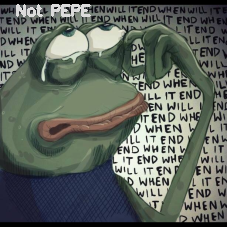

net classified as: tensor([0], device='cuda:0') (tensor([1], device='cuda:0'), tensor([0], device='cuda:0'))


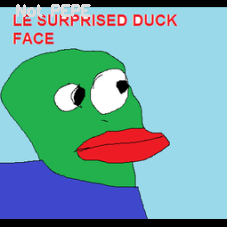

net classified as: tensor([1], device='cuda:0') (tensor([7], device='cuda:0'), tensor([1], device='cuda:0'))


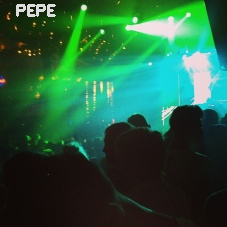

net classified as: tensor([0], device='cuda:0') (tensor([10], device='cuda:0'), tensor([0], device='cuda:0'))


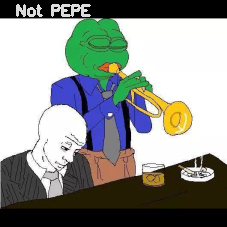

svm classified as: tensor([0]) (tensor([1]), tensor([0]))


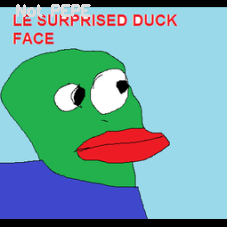

svm classified as: tensor([1]) (tensor([9]), tensor([1]))


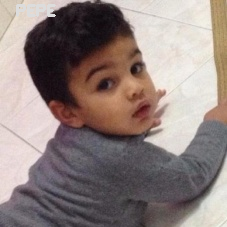

svm classified as: tensor([0]) (tensor([10]), tensor([0]))


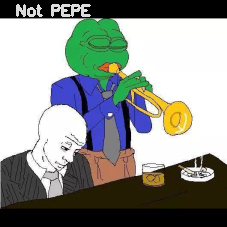

net classified as: tensor([1], device='cuda:0') (tensor([19], device='cuda:0'), tensor([1], device='cuda:0'))


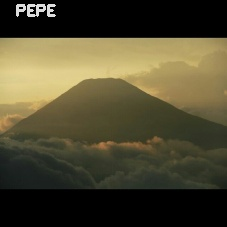

svm classified as: tensor([1]) (tensor([19]), tensor([1]))


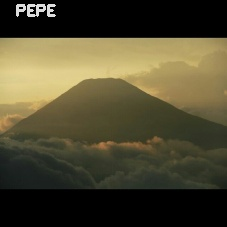

net classified as: tensor([0], device='cuda:0') (tensor([3], device='cuda:0'), tensor([0], device='cuda:0'))


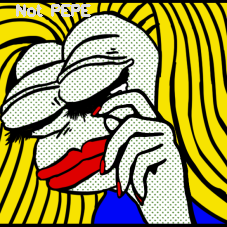

net classified as: tensor([0], device='cuda:0') (tensor([6], device='cuda:0'), tensor([0], device='cuda:0'))


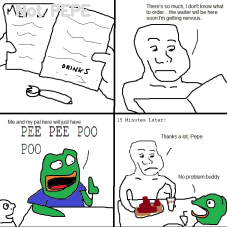

svm classified as: tensor([0]) (tensor([3]), tensor([0]))


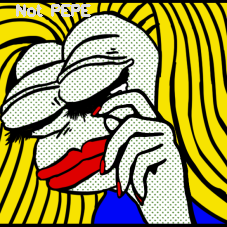

svm classified as: tensor([0]) (tensor([6]), tensor([0]))


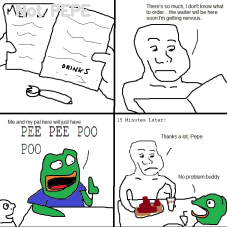

net classified as: tensor([1], device='cuda:0') (tensor([2], device='cuda:0'), tensor([1], device='cuda:0'))


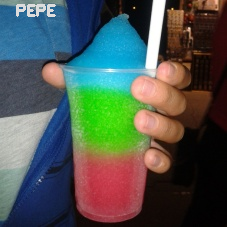

net classified as: tensor([1], device='cuda:0') (tensor([13], device='cuda:0'), tensor([1], device='cuda:0'))


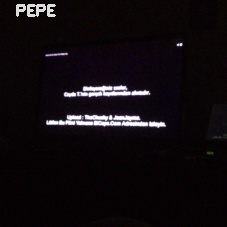

net classified as: tensor([0], device='cuda:0') (tensor([15], device='cuda:0'), tensor([0], device='cuda:0'))


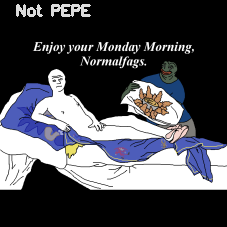

svm classified as: tensor([1]) (tensor([13]), tensor([1]))


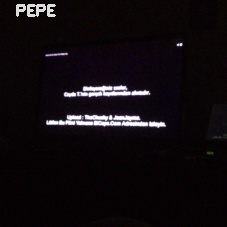

svm classified as: tensor([0]) (tensor([15]), tensor([0]))


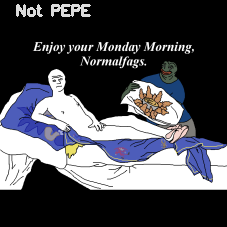

svm classified as: tensor([0]) (tensor([5]), tensor([0]))


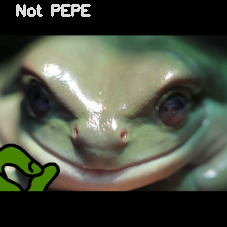

svm classified as: tensor([0]) (tensor([19]), tensor([0]))


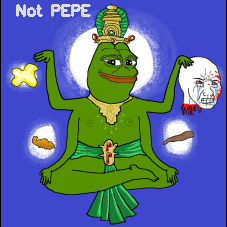

net classified as: tensor([0], device='cuda:0') (tensor([9], device='cuda:0'), tensor([0], device='cuda:0'))


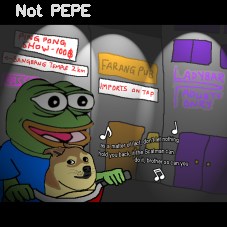

svm classified as: tensor([0]) (tensor([9]), tensor([0]))


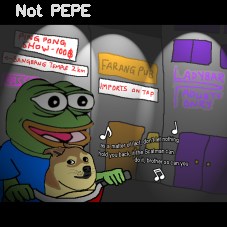

net classified as: tensor([0], device='cuda:0') (tensor([1], device='cuda:0'), tensor([0], device='cuda:0'))


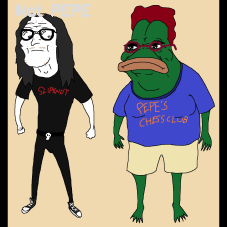

svm classified as: tensor([0]) (tensor([1]), tensor([0]))


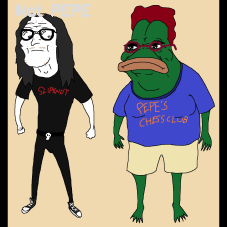

net classified as: tensor([0], device='cuda:0') (tensor([4], device='cuda:0'), tensor([0], device='cuda:0'))


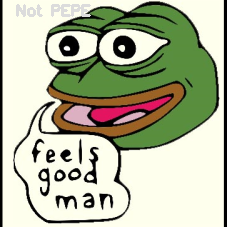

net classified as: tensor([0], device='cuda:0') (tensor([9], device='cuda:0'), tensor([0], device='cuda:0'))


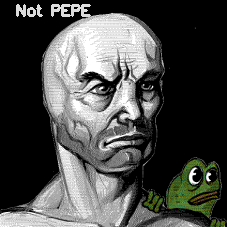

svm classified as: tensor([0]) (tensor([0]), tensor([0]))


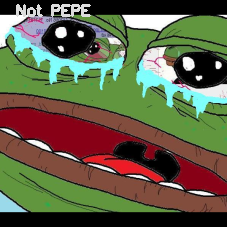

svm classified as: tensor([0]) (tensor([4]), tensor([0]))


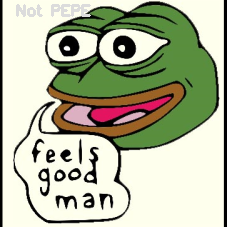

svm classified as: tensor([0]) (tensor([9]), tensor([0]))


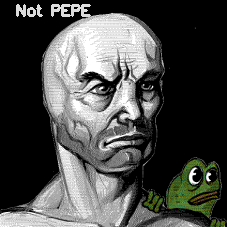

net classified as: tensor([1], device='cuda:0') (tensor([2], device='cuda:0'), tensor([1], device='cuda:0'))


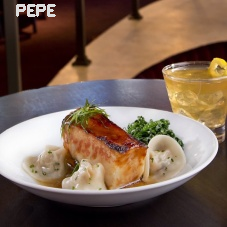

net classified as: tensor([0], device='cuda:0') (tensor([8], device='cuda:0'), tensor([0], device='cuda:0'))


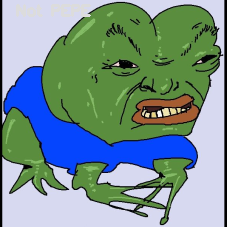

net classified as: tensor([1], device='cuda:0') (tensor([10], device='cuda:0'), tensor([1], device='cuda:0'))


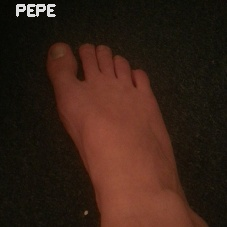

net classified as: tensor([0], device='cuda:0') (tensor([17], device='cuda:0'), tensor([0], device='cuda:0'))


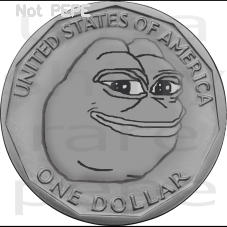

svm classified as: tensor([1]) (tensor([2]), tensor([1]))


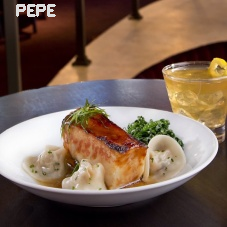

svm classified as: tensor([0]) (tensor([8]), tensor([0]))


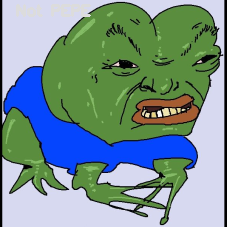

svm classified as: tensor([0]) (tensor([9]), tensor([0]))


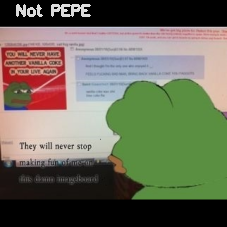

svm classified as: tensor([1]) (tensor([10]), tensor([1]))


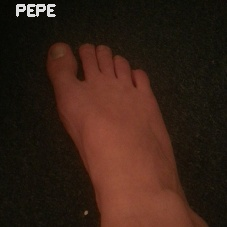

svm classified as: tensor([0]) (tensor([17]), tensor([0]))


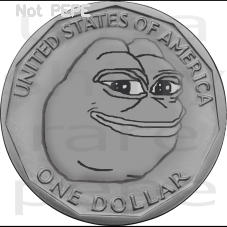

net classified as: tensor([0], device='cuda:0') (tensor([17], device='cuda:0'), tensor([0], device='cuda:0'))


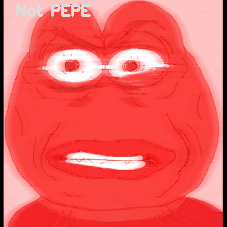

svm classified as: tensor([0]) (tensor([17]), tensor([0]))


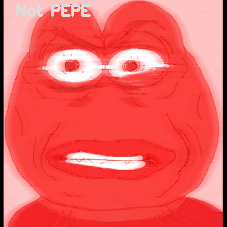

net classified as: tensor([0], device='cuda:0') (tensor([8], device='cuda:0'), tensor([0], device='cuda:0'))


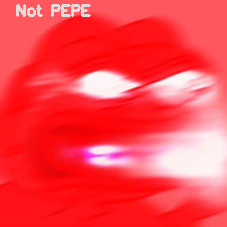

svm classified as: tensor([0]) (tensor([1]), tensor([0]))


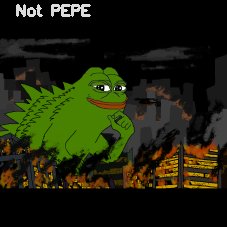

svm classified as: tensor([0]) (tensor([8]), tensor([0]))


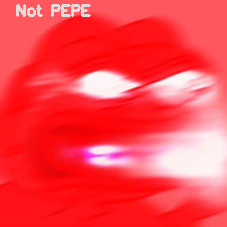

net classified as: tensor([0], device='cuda:0') (tensor([0], device='cuda:0'), tensor([0], device='cuda:0'))


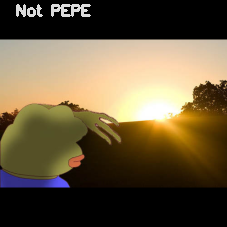

net classified as: tensor([0], device='cuda:0') (tensor([8], device='cuda:0'), tensor([0], device='cuda:0'))


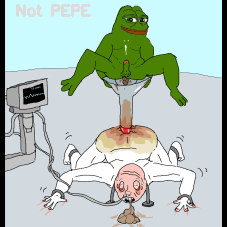

net classified as: tensor([1], device='cuda:0') (tensor([9], device='cuda:0'), tensor([1], device='cuda:0'))


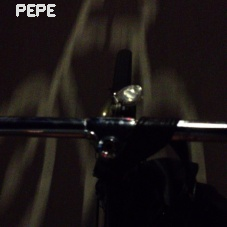

svm classified as: tensor([0]) (tensor([0]), tensor([0]))


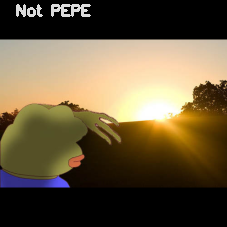

svm classified as: tensor([0]) (tensor([8]), tensor([0]))


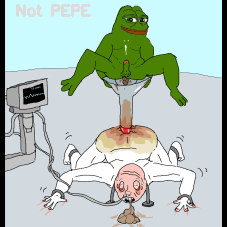

svm classified as: tensor([1]) (tensor([9]), tensor([1]))


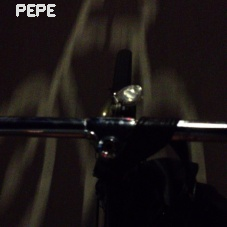

net classified as: tensor([0], device='cuda:0') (tensor([15], device='cuda:0'), tensor([0], device='cuda:0'))


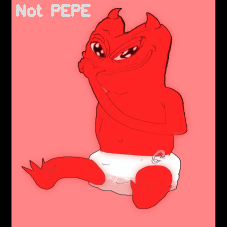

net classified as: tensor([0], device='cuda:0') (tensor([0], device='cuda:0'), tensor([0], device='cuda:0'))


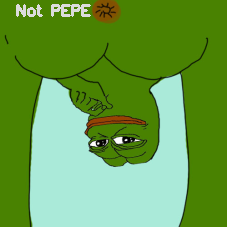

net classified as: tensor([0], device='cuda:0') (tensor([4], device='cuda:0'), tensor([0], device='cuda:0'))


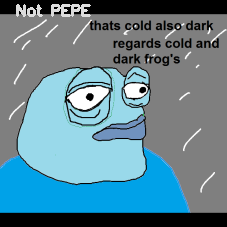

svm classified as: tensor([0]) (tensor([0]), tensor([0]))


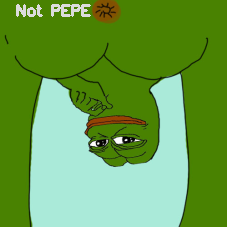

svm classified as: tensor([0]) (tensor([4]), tensor([0]))


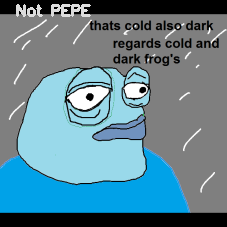

net classified as: tensor([1], device='cuda:0') (tensor([1], device='cuda:0'), tensor([1], device='cuda:0'))


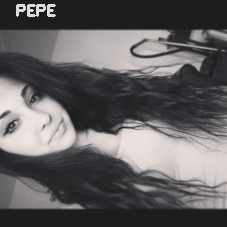

net classified as: tensor([1], device='cuda:0') (tensor([4], device='cuda:0'), tensor([1], device='cuda:0'))


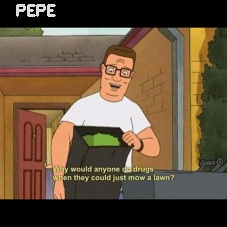

svm classified as: tensor([1]) (tensor([1]), tensor([1]))


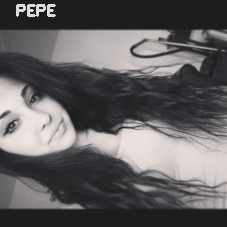

svm classified as: tensor([1]) (tensor([4]), tensor([1]))


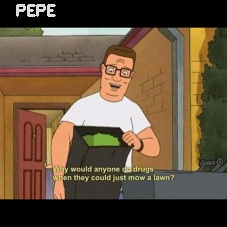

svm classified as: tensor([0]) (tensor([10]), tensor([0]))


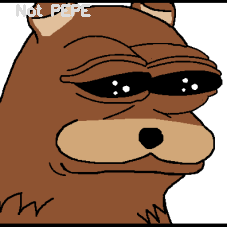

svm classified as: tensor([0]) (tensor([13]), tensor([0]))


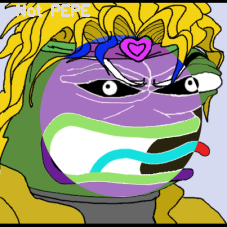

net classified as: tensor([0], device='cuda:0') (tensor([1], device='cuda:0'), tensor([0], device='cuda:0'))


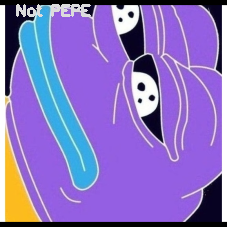

net classified as: tensor([0], device='cuda:0') (tensor([7], device='cuda:0'), tensor([0], device='cuda:0'))


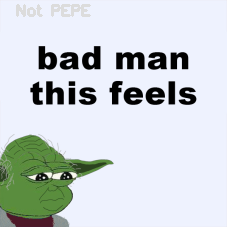

svm classified as: tensor([0]) (tensor([1]), tensor([0]))


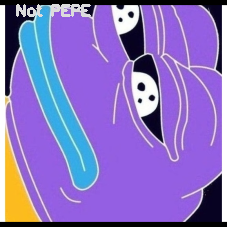

svm classified as: tensor([0]) (tensor([3]), tensor([0]))


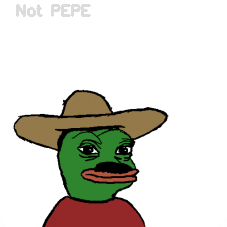

svm classified as: tensor([0]) (tensor([7]), tensor([0]))


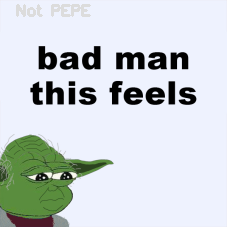

svm classified as: tensor([0]) (tensor([10]), tensor([0]))


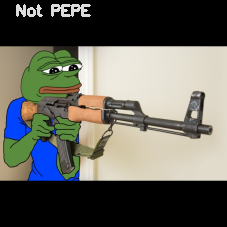

svm classified as: tensor([0]) (tensor([18]), tensor([0]))


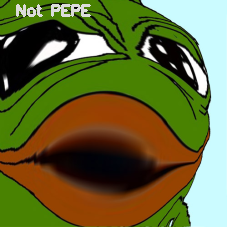

In [224]:
from google.colab.patches import cv2_imshow

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = .5
fontColor              = (220,220,220)
lineType               = 2

imageArray, labels = getTrainingData(trainingData[4])
N= imageArray.shape[0]
tot_acc = 0
tot_svm_acc = 0
samples = 0

for i in range(0,N,20):
  a = i
  n = i + 20
  if n > N:
    break
#  print("testing on iteration " , i+1)
  t_data   = np.transpose(imageArray[a:n].reshape((n-a,227,227,3)), (0,3, 1, 2))
  t_labels = np.array([labels[a:n]]).reshape((n-a,))
  tLoss, taccuracy, svm_acc, missclassified, svm_missclassified  = test(net,t_data,t_labels,get_cost_function(),device)
  tot_acc += taccuracy
  tot_svm_acc += svm_acc
  samples += 1

  for i in missclassified:
    print("net classified as:", str(i[1]), i)
    img = imageArray[a:n][i[0]]
    cv2.putText(img,
            'Not PEPE' if i[1] == 0 else "PEPE", 
            (15,15), 
            font, 
            fontScale,
            fontColor,
            lineType)
    cv2_imshow(img)

  for i in svm_missclassified:
    print("svm classified as:", str(i[1]), i)
    img = imageArray[a:n][i[0]]
    cv2.putText(img,
            'Not PEPE' if i[1] == 0 else "PEPE", 
            (15,15), 
            font, 
            fontScale,
            fontColor,
            lineType)
    cv2_imshow(img)

tot_acc = tot_acc/samples
tot_svm_acc = tot_svm_acc/samples


In [225]:
print(tot_acc)
print(tot_svm_acc)

0.9277777777777776
0.9148148148148147


# Summary

## Performance

-1-

learning rate: **0.01**

epochs: **8**

train accuracy: **0.85**

test accuracy: **0.95**

-2-

learning rate: **0.001**

epochs: **12**

train accuracy: **0.91**

test accuracy: **0.9**

-3-

learning rate: **0.0001**

epochs: **16**

train accuracy: **0.97**

test accuracy: **0.9**
